In [1]:
import logging.config
from logging import Logger, getLogger
from typing import List

from pytket.extensions.qulacs import QulacsBackend as TketQulacsBackend

from qlbm.components import (
    CQLBM,
)
from qlbm.infra import CircuitCompiler
from qlbm.lattice import CollisionlessLattice
from qlbm.tools.utils import create_directory_and_parents, get_circuit_properties


In [2]:
# Import analysis and plotting utilities
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme()

In [8]:
def benchmark(
    lattice_dicts,
    logger: Logger,
    dummy_logger: Logger,
    compiler_platform: List[str],
    target_platform: List[str],
    optimization_levels: List[int],
    backend: TketQulacsBackend | None,
    num_repetitions: int = 5,
) -> None:
    for rep in range(num_repetitions):
        logger.info(f"Repetition #{rep + 1} of {num_repetitions}")
        for count, lattice_dict in enumerate(lattice_dicts):
            for opt_count, optimization_level in enumerate(optimization_levels):
                logger.info(
                    f"Combination #{(count * len(optimization_levels)) + opt_count + 1} of {len(lattice_dicts)*len(optimization_levels)}"
                )

                lattice = CollisionlessLattice(lattice_dict, logger=dummy_logger)

                logger.info(
                    f"Lattice: {lattice.logger_name()}; compiler={compiler_platform}; opt={optimization_level}; num_qubits={lattice.num_total_qubits};"
                )

                algorithm = CQLBM(lattice, logger=dummy_logger)
                logger.info(
                    f"Original circuit has properties: {get_circuit_properties(algorithm.circuit)}"
                )
                compiler = CircuitCompiler(
                    compiler_platform, target_platform, logger=logger
                )

                compiler.compile(
                    compile_object=algorithm,
                    backend=backend,
                    optimization_level=optimization_level,
                )

In [9]:
NUM_SHOTS = 2**14
NUM_STEPS = 5
ROOT_OUTPUT_DIR = "qlbm-output/benchmark-algorithm-scalability"

create_directory_and_parents(ROOT_OUTPUT_DIR)

In [10]:
!mkdir -p qlbm-output/benchmark-algorithm-scalability && touch qlbm-output/benchmark-algorithm-scalability/qlbm.log
!:> qlbm-output/benchmark-algorithm-scalability/qlbm.log

In [11]:
lattices = [
    {
        "lattice": {"dim": {"x": 8, "y": 8}, "velocities": {"x": 4, "y": 4}},
        "geometry": [],
    },  # 0 Obstacles
    {
        "lattice": {"dim": {"x": 8, "y": 8}, "velocities": {"x": 4, "y": 4}},
        "geometry": [{"x": [5, 6], "y": [1, 2], "boundary": "specular"}],
    },  # 1 Obstacle
    {
        "lattice": {"dim": {"x": 8, "y": 8}, "velocities": {"x": 4, "y": 4}},
        "geometry": [
            {"x": [5, 6], "y": [1, 2], "boundary": "specular"},
            {"x": [5, 6], "y": [5, 6], "boundary": "specular"},
        ],
    },  # 2 Obstacles
]

dummy_logger = getLogger("dummy")
# By logging at this point we ignore the output of circuit creation
logging.config.fileConfig("algorithm_scalability_logging.conf")
logger = getLogger("qlbm")

In [12]:
logger.info("Session: QISKIT")
benchmark(
    lattices,
    logger,
    dummy_logger,
    "QISKIT",
    "QULACS",
    [0],
    None,
    num_repetitions=1,
)

/home/calin/phd/qlbm/.venv/lib64/python3.11/site-packages/qiskit/providers/backend_compat.py:126: RuntimeWarning: No gate definition for unitary can be found and is being excluded from the generated target. You can use `custom_name_mapping` to provide a definition for this operation.
  warnings.warn(
/home/calin/phd/qlbm/.venv/lib64/python3.11/site-packages/qiskit/providers/backend_compat.py:126: RuntimeWarning: No gate definition for unitary can be found and is being excluded from the generated target. You can use `custom_name_mapping` to provide a definition for this operation.
  warnings.warn(
/home/calin/phd/qlbm/.venv/lib64/python3.11/site-packages/qiskit/providers/backend_compat.py:126: RuntimeWarning: No gate definition for unitary can be found and is being excluded from the generated target. You can use `custom_name_mapping` to provide a definition for this operation.
  warnings.warn(


In [13]:
logger.info("Session: TKET")
benchmark(
    lattices,
    logger,
    dummy_logger,
    "TKET",
    "QULACS",
    [0],
    TketQulacsBackend(),
    num_repetitions=1,
)


In [14]:
log_file = "qlbm-output/benchmark-algorithm-scalability/qlbm.log"
with open(log_file, "r") as f:
    lines = f.readlines()

session_line = [c for c, line in enumerate(lines) if "Session" in line][1]

lines_qiskit = lines[:session_line]
lines_tket = lines[session_line:]

In [16]:
combination_lines_indices_qiskit, combination_lines_indices_tket = (
    [c for c, line in enumerate(lines_qiskit) if "Combination #" in line],
    [c for c, line in enumerate(lines_tket) if "Combination #" in line],
)
print(len(combination_lines_indices_qiskit + combination_lines_indices_tket))
sections = []
for c in range(len(combination_lines_indices_qiskit + combination_lines_indices_tket)):
    if c < len(combination_lines_indices_qiskit):
        if c < len(combination_lines_indices_qiskit) - 1:
            sections.append(
                lines_qiskit[
                    combination_lines_indices_qiskit[
                        c
                    ] : combination_lines_indices_qiskit[c + 1]
                ]
            )
        else:
            sections.append(lines_qiskit[combination_lines_indices_qiskit[c] :])
    else:
        c_tket = c - len(combination_lines_indices_qiskit)
        if c_tket < len(combination_lines_indices_tket) - 1:
            sections.append(
                lines_tket[
                    combination_lines_indices_tket[
                        c_tket
                    ] : combination_lines_indices_tket[c_tket + 1]
                ]
            )
        else:
            sections.append(lines_tket[combination_lines_indices_tket[c_tket] :])

records = []
for c, section in enumerate(sections):
    section_info = (
        [line for line in section if "Lattice: " in line][0]
        .rstrip("\n")
        .split(": ")[-1]
        .split("; ")
    )
    lattice_name = section_info[0]
    compiler_platform = section_info[1].split("=")[-1]
    opt_level = section_info[2].split("=")[-1]
    num_qubits = section_info[3].split("=")[-1][:-1]

    original_props = (
        [line for line in section if "Original circuit" in line][0]
        .split("(")[-1]
        .rstrip("\n)")
        .split(", ")
    )
    compiled_props = (
        [line for line in section if "Compiled circuit" in line][0]
        .split("(")[-1]
        .rstrip("\n)")
        .split(", ")
    )
    duration = int(
        [line for line in section if "Compilation took" in line][0].split()[-2]
    )

    records.append(
        {
            "Lattice": lattice_name,
            "Dimensions": lattice_name.split("-")[1],
            "Obstacles": int(lattice_name.split("-")[2]),
            "Circuit Qubits": num_qubits,
            "Initial Depth": int(original_props[2]),
            "Initial Gate No.": int(original_props[3]),
            "Compiled Depth": int(compiled_props[2]),
            "Compiled Gate No.": int(compiled_props[3]),
            "Duration (ns)": int(duration),
            "Duration (s)": int(duration) / 1e9,
            "Compiler": "QISKIT"
            if c < len(combination_lines_indices_qiskit)
            else "TKET",
        }
    )

df = pd.DataFrame.from_records(records)

df

6


,Lattice,Dimensions,Obstacles,Circuit Qubits,Initial Depth,Initial Gate No.,Compiled Depth,Compiled Gate No.,Duration (ns),Duration (s),Compiler
0,2d-7x7-0-obstacle,7x7,0,16,102,213,1048,2160,475105420,0.475105,QISKIT
1,2d-7x7-1-obstacle,7x7,1,16,705,1761,56145,84672,12142859904,12.142860,QISKIT
2,2d-7x7-2-obstacle,7x7,2,16,1371,3213,111837,167088,23261293762,23.261294,QISKIT
3,2d-7x7-0-obstacle,7x7,0,16,102,213,1048,2160,436541094,0.436541,TKET
4,2d-7x7-1-obstacle,7x7,1,16,705,1761,54234,96384,2530288380,2.530288,TKET
5,2d-7x7-2-obstacle,7x7,2,16,1371,3213,108426,190512,4772455758,4.772456,TKET


Text(0.5, 1.0, 'Compilation Depth Comparison')

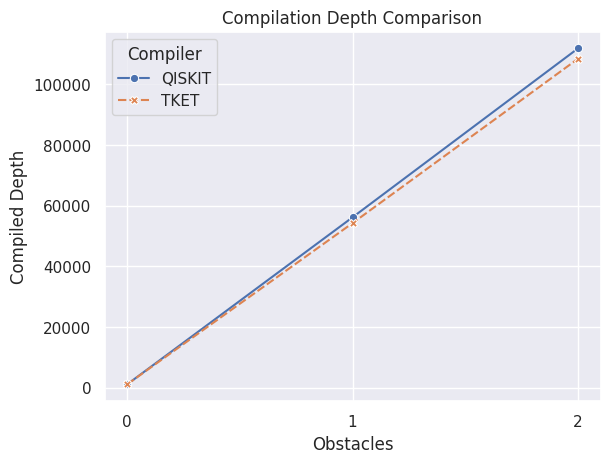

In [28]:
sns.lineplot(
    df,
    x="Obstacles",
    y="Compiled Depth",
    hue="Compiler",
    style="Compiler",
    markers=True,
)
plt.xticks(pd.unique(df["Obstacles"]))
plt.title("Compilation Depth Comparison")

Text(0.5, 1.0, 'Compilation Gate Comparison')

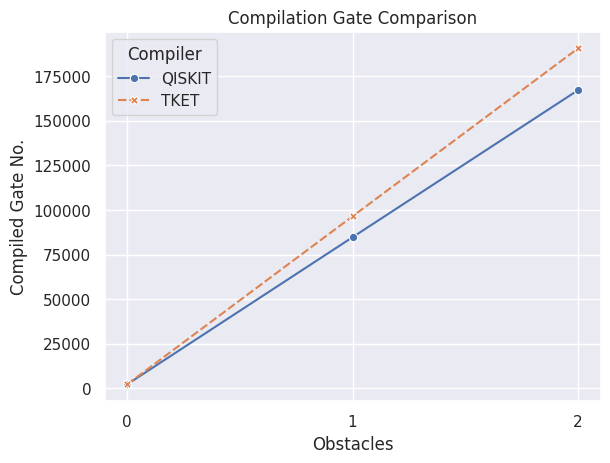

In [29]:
sns.lineplot(
    df,
    x="Obstacles",
    y="Compiled Gate No.",
    hue="Compiler",
    style="Compiler",
    markers=True,
)
plt.xticks(pd.unique(df["Obstacles"]))
plt.title("Compilation Gate Comparison")

Text(0.5, 1.0, 'Compilation Duration Comparison')

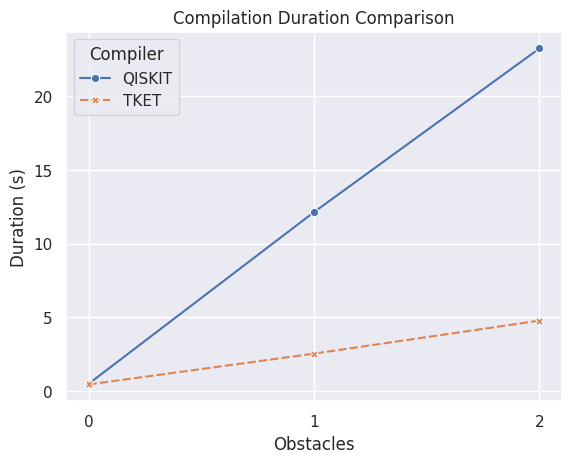

In [27]:
g = sns.lineplot(
    df,
    x="Obstacles",
    y="Duration (s)",
    hue="Compiler",
    style="Compiler",
    markers=True,
)
plt.xticks(pd.unique(df["Obstacles"]))
plt.title("Compilation Duration Comparison")

array([0, 1, 2])